In [248]:
import os
import numpy as np
import cv2 
import pandas as pd
from PIL import Image, ImageStat
import matplotlib.pyplot as plt
np.random.seed(0)

In [249]:
def get_sample_fts(sample: np.array):
    #sample = cv2.fastNlMeansDenoisingColored(sample, h=15, hColor=5) 
    img = Image.fromarray(sample)
    mean_hue, mean_sat, mean_val = ImageStat.Stat(img).mean
    
    img_hsv = cv2.cvtColor(sample, cv2.COLOR_RGB2HSV)
    dark = (0, 0, mean_val/2) 
    light = (179, 255, 255)
    img_gray = cv2.cvtColor(sample, cv2.COLOR_RGB2GRAY)
    mask_yel = cv2.inRange(img_hsv, dark, light)
    img_yel = cv2.bitwise_and(img_gray, img_gray, mask=mask_yel)
    size = len(sample) * len(sample[0])
    area = sum([sum([0 if pxl == 0 else 1 for pxl in row])for row in img_yel])
    intensity = sum([sum(row) for row in img_yel]) / (area*mean_val) if area != 0 else 0
    
    sample_fts = [area/size, intensity, mean_hue, mean_sat, mean_val]
    return sample_fts

In [250]:
df = pd.DataFrame(columns=['Sample', 'Area', 'Intensity', 'Hue', 'Saturation', 'Value', 'Oil'])
samples_path = 'data/samples/oil/'

k = 1
for direc in os.listdir(samples_path):
    
    folder = os.listdir(samples_path+direc)
    num = len(folder)
    i = 1
    print('\n'+direc+':\n')
    
    for sample_path in folder:
        sample = plt.imread(samples_path+direc+'/'+sample_path)
        sample_fts = get_sample_fts(sample)
        
        row = [sample_path[:-5]]
        row.extend(sample_fts)
        row.append(direc)
        
        df.loc[k] = row
  
        if i % 100 == 0 or i == num:
            print(str(i)+'/'+str(num))
        k += 1
        i += 1


low:

100/770
200/770
300/770
400/770
500/770
600/770
700/770
770/770

no:

100/931
200/931
300/931
400/931
500/931
600/931
700/931
800/931
900/931
931/931

high:

100/515
200/515
300/515
400/515
500/515
515/515


In [251]:
X = np.array([row[1:7] for row in df.itertuples()])
y = np.array([row[7] for row in df.itertuples()])

In [252]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer, confusion_matrix
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
def score(model, X, y, cv):
    scores = cross_val_score(model, X, y,
                              cv=cv,
                              scoring=make_scorer(balanced_accuracy_score))
    return scores.mean()

In [253]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200, 
                         learning_rate=1, random_state=0)
print('AdaBoost: ', score(ada, [x[1:] for x in X], y, cv))

rfc = RandomForestClassifier(n_estimators=200, random_state=0)
print('RandomForestClassifier: ', score(rfc, [x[1:] for x in X], y, cv))

gbc = GradientBoostingClassifier(n_estimators=200, random_state=0)
print('GradientBoostingClassifier: ', score(gbc, [x[1:] for x in X], y, cv))

AdaBoost:  0.7514315438202787
RandomForestClassifier:  0.8583720237917296
GradientBoostingClassifier:  0.8186900079296523


In [254]:
print(ada.fit([x[1:] for x in X],y).feature_importances_)
print(rfc.fit([x[1:] for x in X],y).feature_importances_)
print(gbc.fit([x[1:] for x in X],y).feature_importances_)

[0.22893813 0.13646334 0.1628771  0.30299636 0.16872507]
[0.1806474  0.13776426 0.15400838 0.21166743 0.31591252]
[0.20252757 0.09762964 0.08780456 0.17781822 0.43422   ]


In [257]:
def multi_score(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model = model.fit([x[1:] for x in X_train], y_train)
    Y = model.predict([x[1:] for x in X_test])
    c = 0
    for i in range(len(Y)):
        if Y[i] == y_test[i]:
            c += 1
        else:
            img = plt.imread('data/samples/oil/'+y_test[i]+'/'+X_test[i][0]+'.jpeg')
            #img = cv2.fastNlMeansDenoisingColored(img, templateWindowSize=7, searchWindowSize=21, 
            #                                      h=25, hColor=5) 
            fig, ax = plt.subplots(figsize=(10,40))
            ax.imshow(img)
            ax.set_title('label: '+y_test[i]+'\npredicted: '+Y[i])
            plt.show()
    print('Accuracy of the model: %d %%' % (
    100 * c / len(Y)))
    lnY = [Y[i] for i in range(len(y_test)) if Y[i] != 'high' and y_test[i] != 'high']
    lny = [y_test[i] for i in range(len(y_test)) if Y[i] != 'high' and y_test[i] != 'high']
    lhY = [Y[i] for i in range(len(y_test)) if Y[i] != 'no' and y_test[i] != 'no']
    lhy = [y_test[i] for i in range(len(y_test)) if Y[i] != 'no' and y_test[i] != 'no']
    nhY = [Y[i] for i in range(len(y_test)) if Y[i] != 'low' and y_test[i] != 'low']
    nhy = [y_test[i] for i in range(len(y_test)) if Y[i] != 'low' and y_test[i] != 'low']
    
    scores = [balanced_accuracy_score(lny, lnY),
              balanced_accuracy_score(nhy, nhY),
              balanced_accuracy_score(lhy, lhY)]
    
    return scores

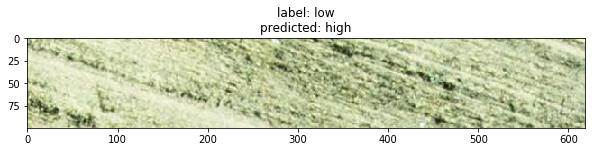

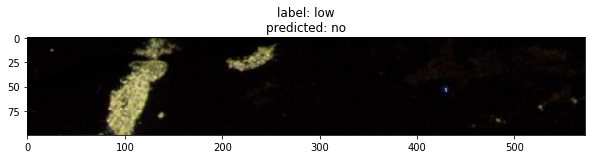

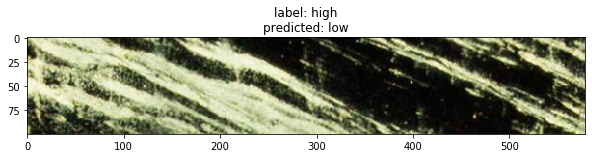

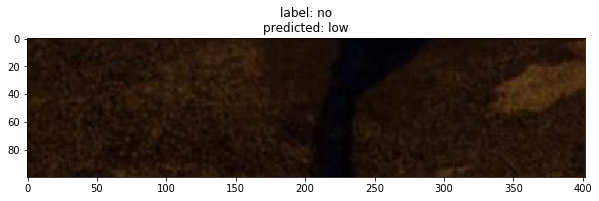

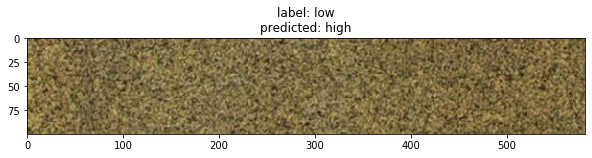

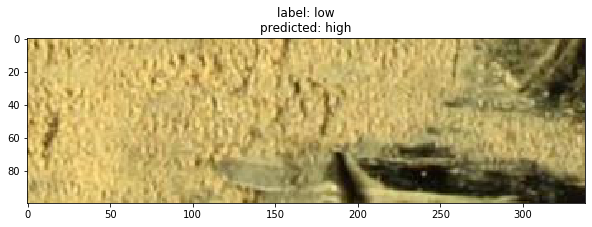

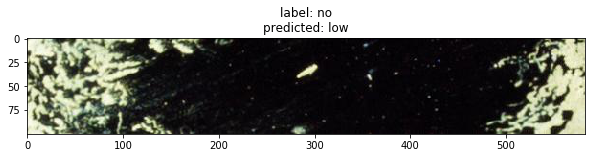

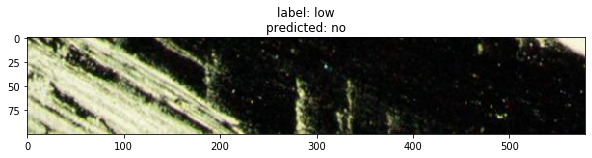

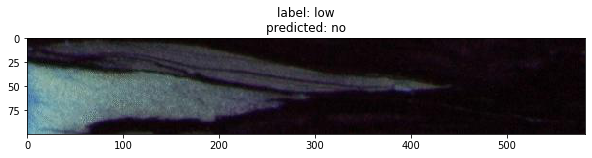

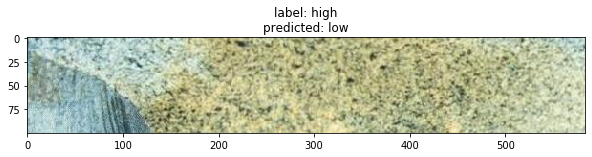

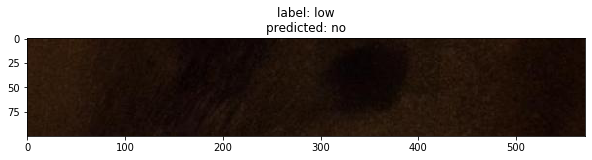

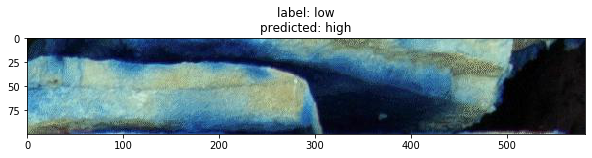

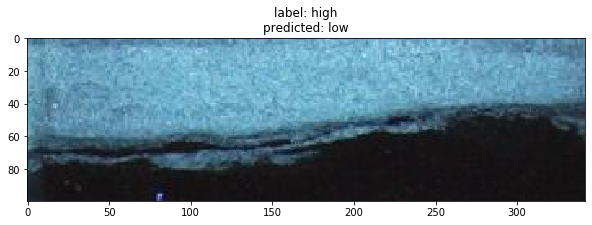

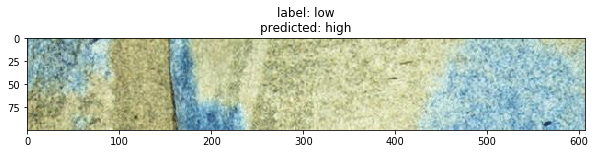

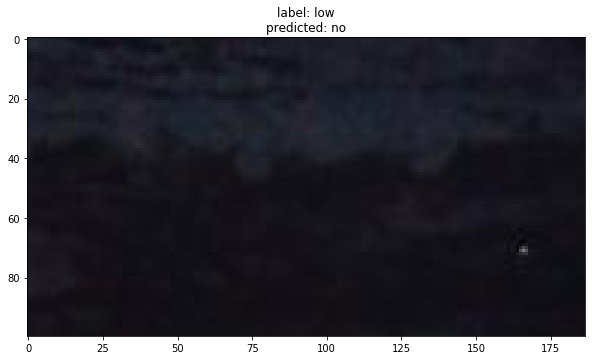

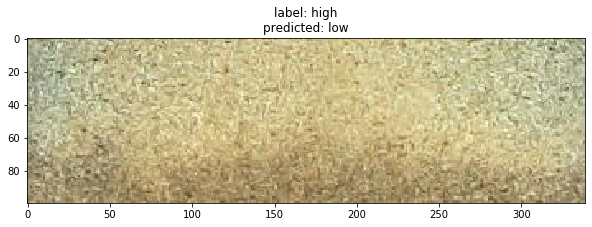

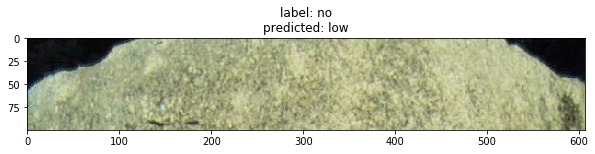

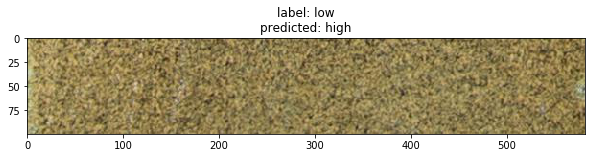

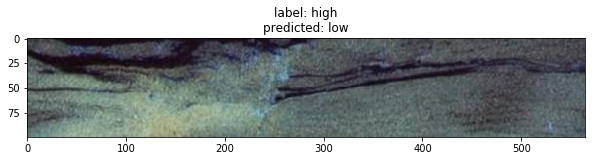

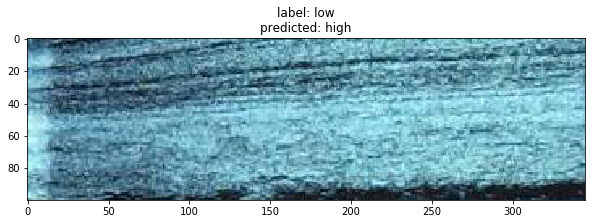

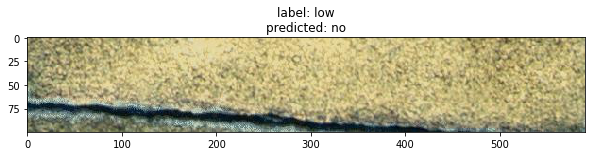

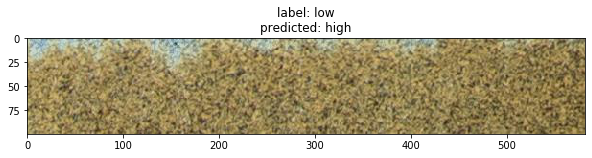

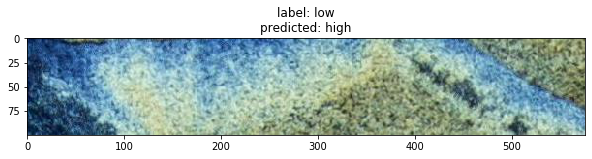

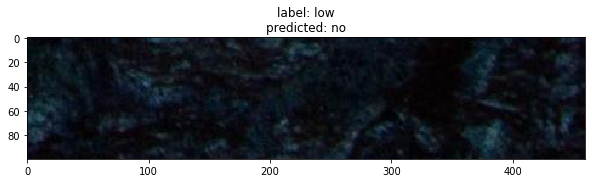

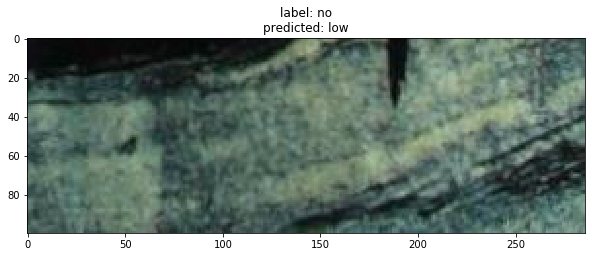

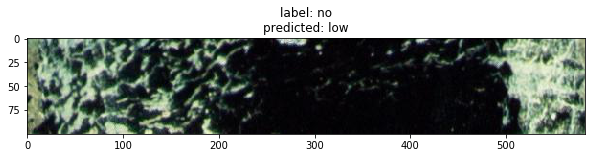

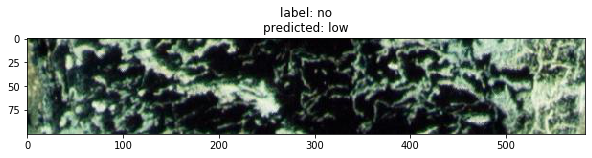

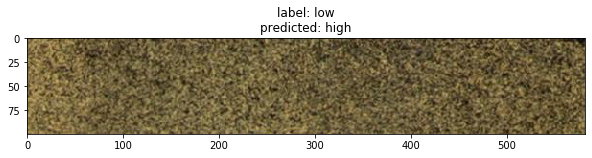

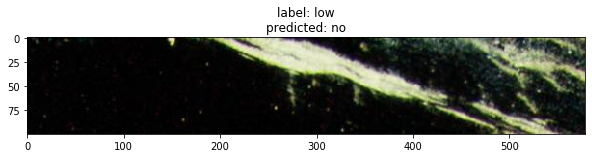

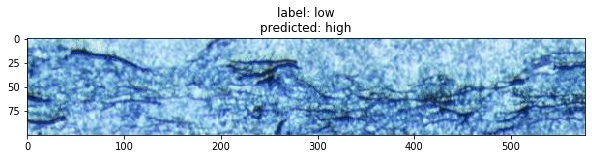

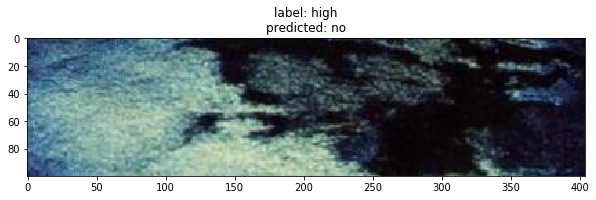

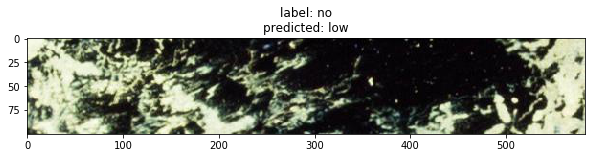

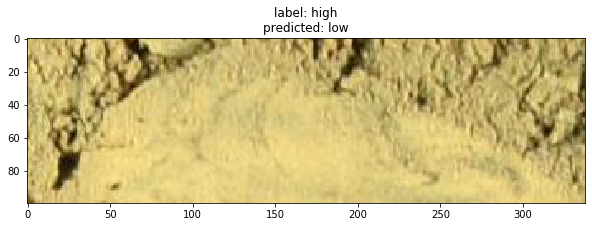

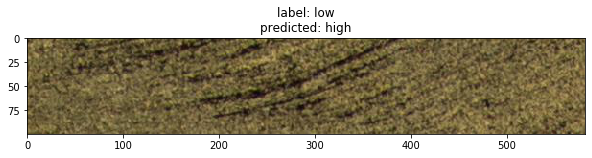

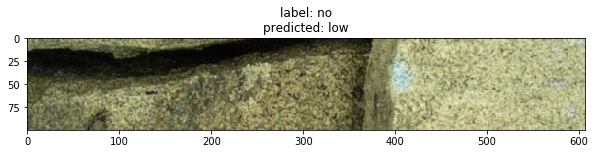

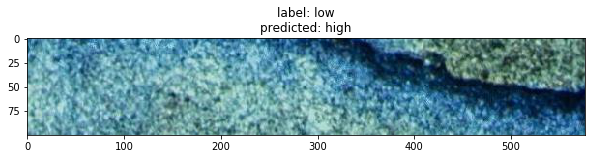

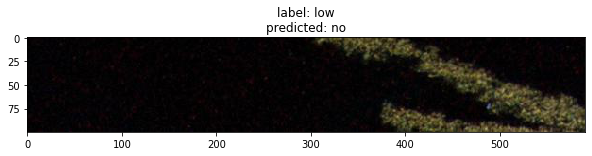

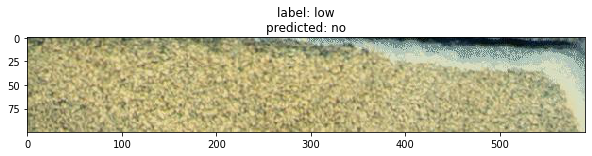

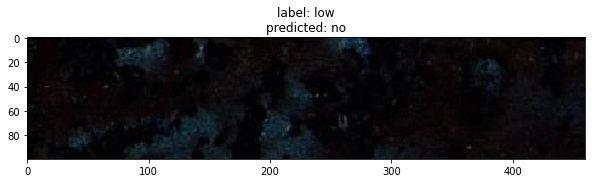

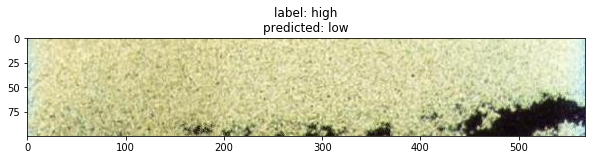

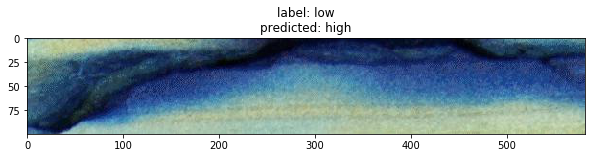

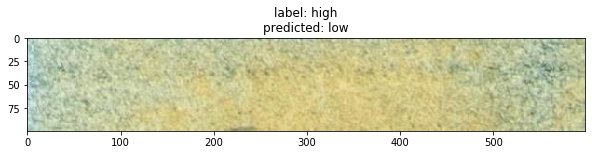

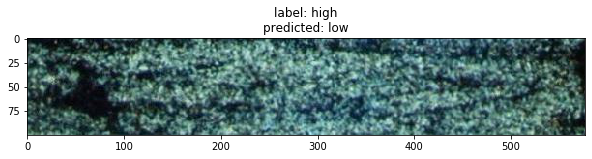

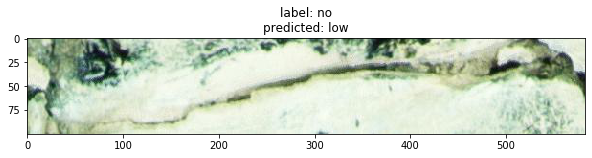

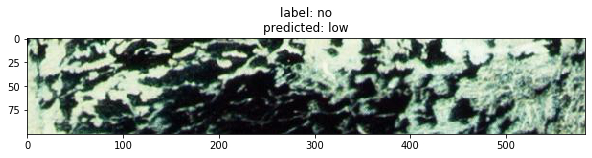

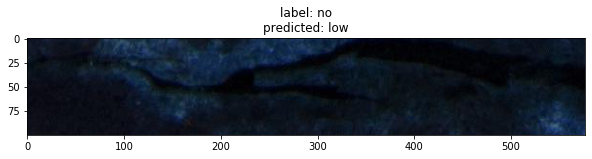

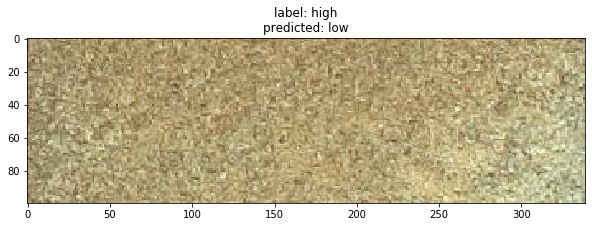

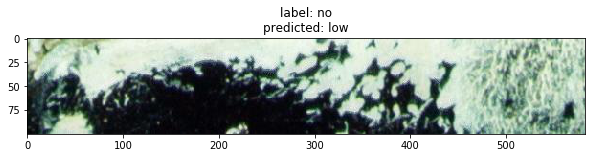

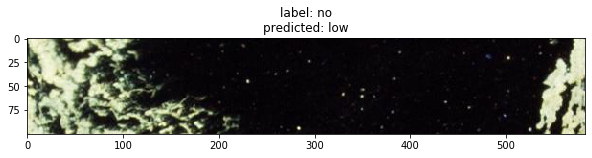

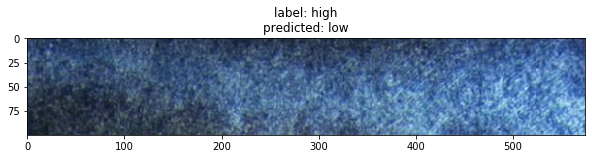

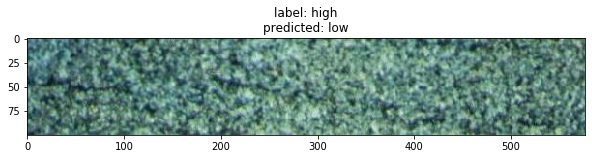

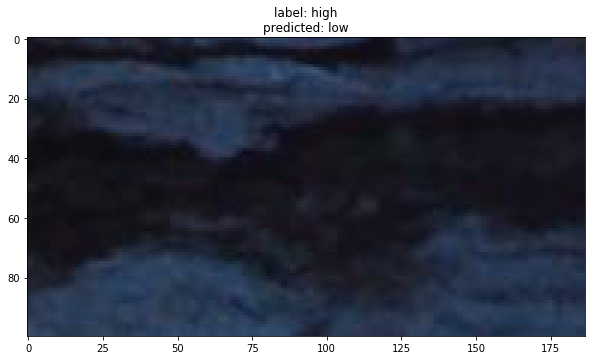

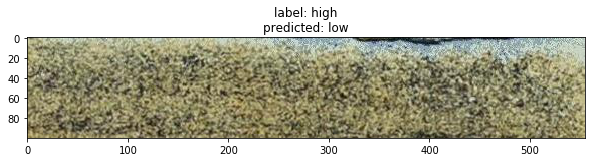

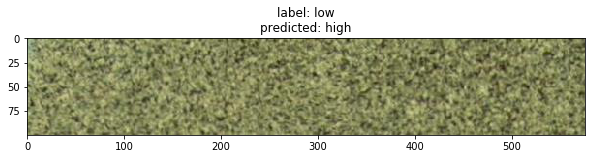

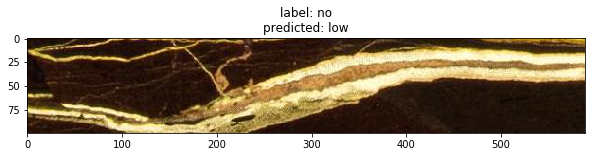

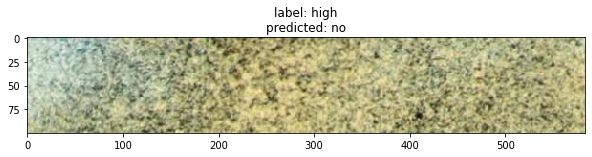

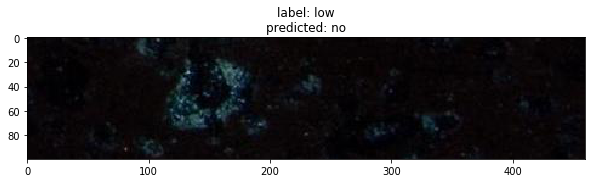

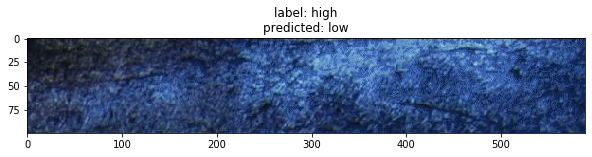

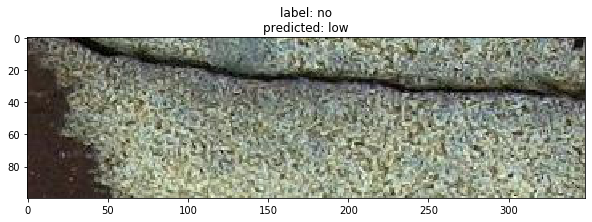

Accuracy of the model: 86 %
[0.9199857752489331, 0.987012987012987, 0.8682795698924731]


In [258]:
ms = multi_score(rfc, X, y)
print(ms)